# Section 1: Data exploration and pre-processing

## Requirements and utilities


In [1]:
!pip install pandas scikit-learn nltk 

In [2]:
!pip install langdetect

In [3]:
!pip install seaborn matplotlib

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import re
import nltk


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Data Exploration
*a. How many different attribute values do you observe in each feature? (e.g. how many
subreddits are there?) Is there any missing or duplicated data? (Referring to textual
features)*

*b. How does the empirical distribution of the number of characters in each comment look
like? How is the distribution of the number of comments per author? Is the supervised
dataset balanced between male and female? Are there only comments in English? Hint: use
the library langdetect.*

In [6]:

# loading the supervised data
df = pd.read_csv('../data/data_supervised.csv') 


print(f"Dataframe size: {df.shape}")
m = df.shape

# count differents subreddit topics and authors
n_distinc_authors = len(pd.unique(df['author']))
print(f"There are {n_distinc_authors} distinct authors")

# count distinct subreddit (topics)
n_distinct_subreddit = len(pd.unique(df['subreddit']))
print(f"There are {n_distinct_subreddit} distinct subreddit")

# count distinct body (comments)
n_distinct_body = len(pd.unique(df['body']))
print(f"There are {n_distinct_body} distinct body")

# checking missing values
print("\nNull value count for each field")
print(df.isna().sum())

# checking empty stirng
print("\nEmpty bodies: ",(df['body'].str.strip() == "").sum())

# checking duplicate values
n_duplicate = df.duplicated().sum()
print(f"Duplicate rows {n_duplicate}")

# count rows with same body.
print("Number of identical bodies: ", df['body'].duplicated().sum())



Dataframe size: (296042, 4)
There are 5000 distinct authors
There are 3468 distinct subreddit
There are 289608 distinct body

Null value count for each field
author         0
subreddit      0
created_utc    0
body           0
dtype: int64

Empty bodies:  0
Duplicate rows 7
Number of identical bodies:  6434


Body char length statistics:
count    296042.000000
mean        183.157228
std         327.155573
min           1.000000
25%          41.000000
50%          90.000000
75%         198.000000
max       14271.000000
Name: char_len, dtype: float64


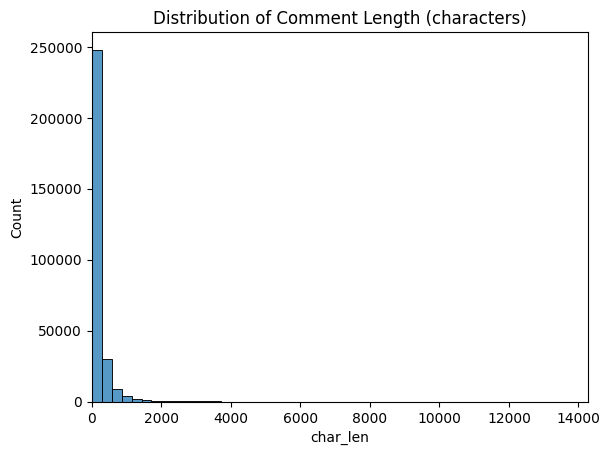

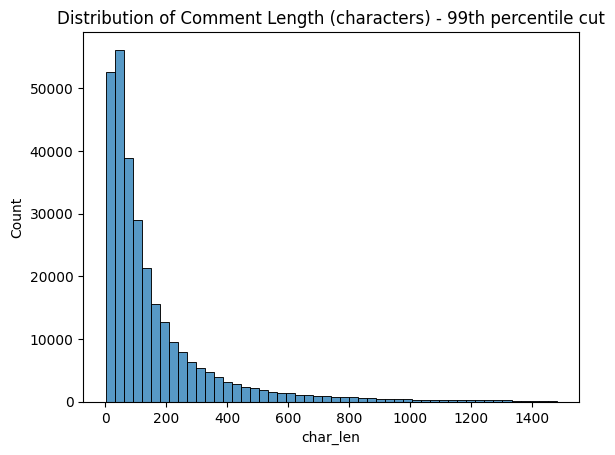

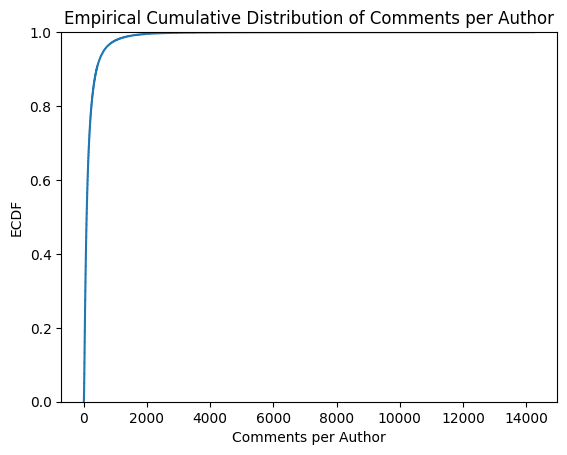

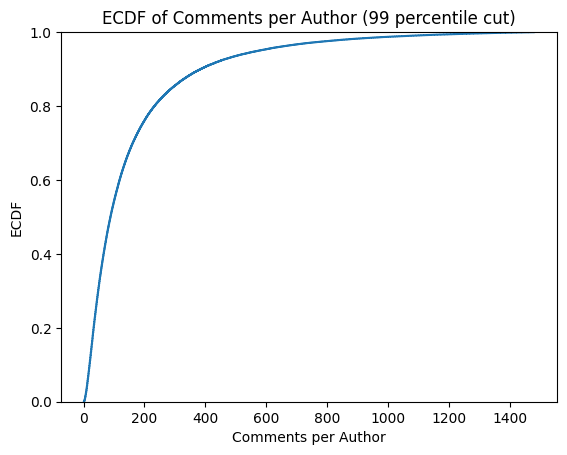

In [7]:
# collect the number of character for each comment
df['char_len'] = df['body'].str.len()

# describing the empirical distribution
print("Body char length statistics:")
print(df['char_len'].describe())

# plot the histogram
sns.histplot(df['char_len'], bins=50)
plt.title("Distribution of Comment Length (characters)")
plt.xlim(0, 14271)
plt.show()

#TODO Scegliere se tenere entrambi o solo uno dei due plot.
#99-percentile plot
per_len_plot = df['char_len']
per_len_plot = per_len_plot[per_len_plot <= per_len_plot.quantile(0.99)]
sns.histplot(per_len_plot, bins=50)
plt.title("Distribution of Comment Length (characters) - 99th percentile cut")
plt.show()

sns.ecdfplot(df['char_len'])
plt.xlabel("Comments per Author")
plt.ylabel("ECDF")
plt.title("Empirical Cumulative Distribution of Comments per Author")
plt.show()

sns.ecdfplot(per_len_plot)
plt.xlabel("Comments per Author")
plt.ylabel("ECDF")
plt.title("ECDF of Comments per Author (99 percentile cut)")
plt.show()


Statistics of number of comments per author
count     5000.000000
mean        59.208400
std        298.134567
min          1.000000
25%          5.000000
50%         16.000000
75%         54.000000
max      19534.000000
Name: count, dtype: float64


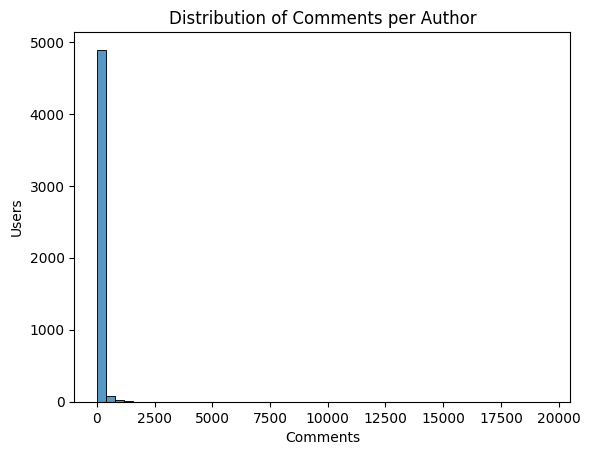

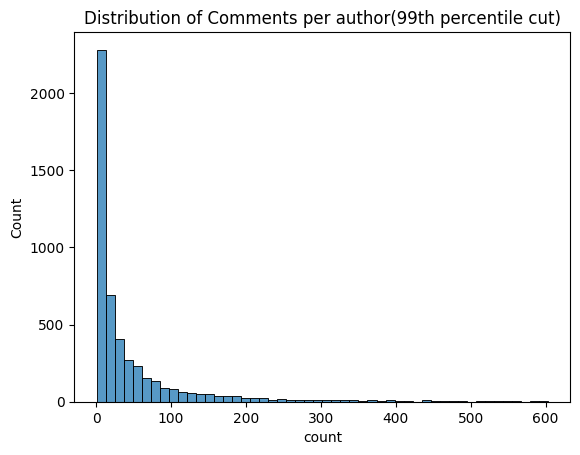

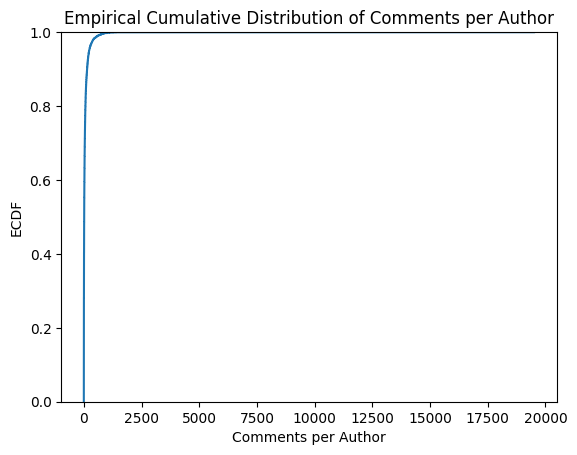

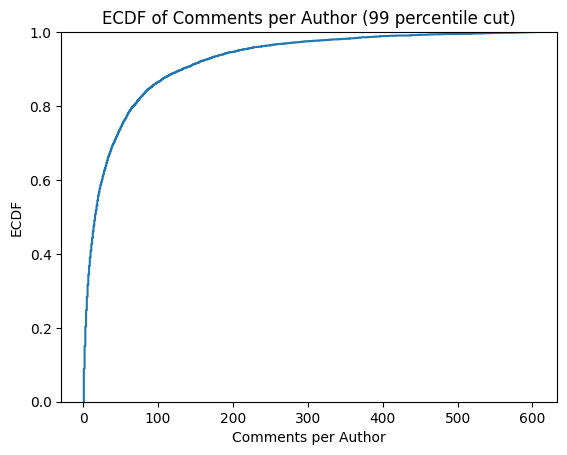

In [8]:
# comments per author
comments_per_author = df['author'].value_counts()
print("Statistics of number of comments per author")
print(comments_per_author.describe())

plt.xlabel("Comments")
plt.ylabel("Users")

# plotting
sns.histplot(comments_per_author, bins=50)
plt.title("Distribution of Comments per Author")
plt.show()

#99-percentile plot
percentile_comments_per_author = comments_per_author[comments_per_author <= comments_per_author.quantile(0.99)]
sns.histplot(percentile_comments_per_author, bins=50)
plt.title("Distribution of Comments per author(99th percentile cut)")
plt.show()


sns.ecdfplot(comments_per_author)
plt.xlabel("Comments per Author")
plt.ylabel("ECDF")
plt.title("Empirical Cumulative Distribution of Comments per Author")
plt.show()

sns.ecdfplot(percentile_comments_per_author)
plt.xlabel("Comments per Author")
plt.ylabel("ECDF")
plt.title("ECDF of Comments per Author (99 percentile cut)")
plt.show()


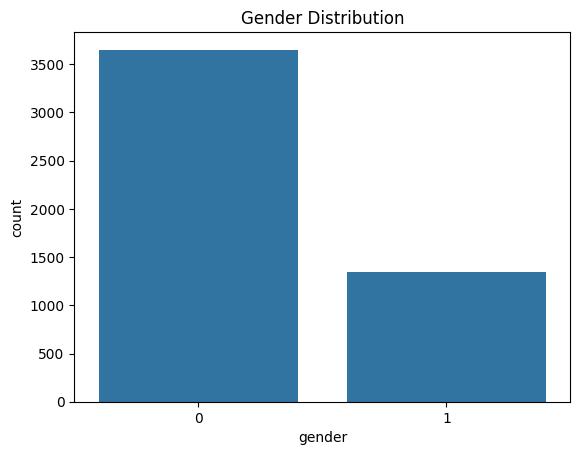

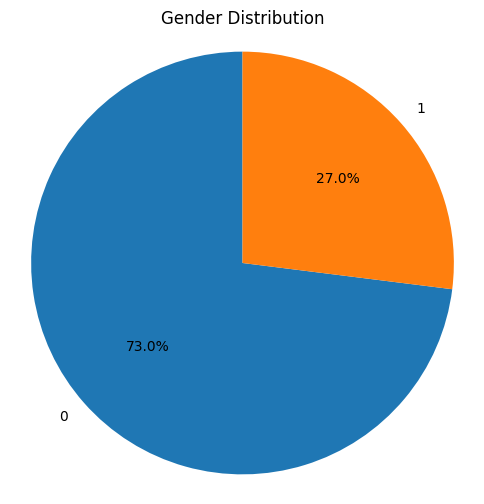

In [9]:
# reading the target_supervised
target = pd.read_csv('../data/target_supervised.csv')

sns.countplot(data=target, x='gender')
plt.title("Gender Distribution")
plt.show()

counts = target['gender'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Gender Distribution")
plt.axis('equal')  # keeps the pie circular
plt.show()


In [10]:
!pip install fasttext

  Using cached fasttext-0.9.3.tar.gz (73 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
Failed to build fasttext


  error: subprocess-exited-with-error
  
  × Building wheel for fasttext (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [45 lines of output]
      C:\Users\ASUS\AppData\Local\Temp\pip-build-env-id35cikb\overlay\Lib\site-packages\setuptools\dist.py:599: SetuptoolsDeprecationWarning: Invalid dash-separated key 'description-file' in 'metadata' (setup.cfg), please use the underscore name 'description_file' instead.
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
              (Affected: fasttext).
      
              By 2026-Mar-03, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.h

## 2. Data Cleaning and Text Standardization.

*a. Uniform text formats (e.g., case normalization, Hint: standardize the letters in lower case).If necessary, clean the comment text (e.g. URLs, subreddit refs, …).*

*b. Stop words are not contributing much to our ML tasks, such as "the", "a", since they carry very little information. Take care of these kinds of words.*

*c. Reduce words to their base or root form using Stemming/Lemmatization. This helps in
reducing inflected words to a common base form. (Hint: Consider using libraries like NLTK
or spaCy for tokenization).*


In [11]:
!pip install spacy

!python -m spacy download en_core_web_sm

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
   ---------------------------------------- 0.0/15.3 MB ? eta -:--:--
   ------------ --------------------------- 4.7/15.3 MB 28.4 MB/s eta 0:00:01
   ---------------------------------------  15.2/15.3 MB 39.8 MB/s eta 0:00:01
   ---------------------------------------- 15.3/15.3 MB 37.1 MB/s  0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 37.3 MB/s  0:00:00
   ---------------------------------------- 0.0/654.0 kB ? eta -:--:--
   ---------------------------------------- 654.0/654.0 kB 26.1 MB/s  0:00:00
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 49.4 MB/s  0:00:00
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 6.2/6.2 MB 53.8 MB/s  0:00:00
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)

   

In [1]:
# import needed python libraries

%matplotlib inline
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import html
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])
from langdetect import detect
import os
from collections import Counter

In [2]:
df_supervised   = pd.read_csv("../data/data_supervised.csv")
df_unsupervised = pd.read_csv("../data/data_unsupervised.csv")
df_target       = pd.read_csv("../data/target_supervised.csv")

print(df_supervised.shape, df_unsupervised.shape, df_target.shape)

(296042, 4) (1107946, 4) (5000, 2)


*Uniform text formats (e.g., case normalization, Hint: standardize the letters in lower case). If necessary, clean the comment text (e.g. URLs, subreddit refs, …).*



In [3]:
remove_pattern = r'https?://\S+|www\.\S+|r/\w+|u/\w+'

df_supervised['body_normalized'] = (
    df_supervised['body']
    .fillna('')                                     # To handling NaN
    .astype(str)                                    # Ensure string format
    .str.lower()                                    # Case normalization (Punto a.)
    .apply(html.unescape)                           # Decoding HTML (es. &amp; -> &)
    .str.replace(remove_pattern, ' ', regex=True)   # Removing URL, r/, u/
    .str.replace(r'\s+', ' ', regex=True)           # Removing double blank spaces
    .str.strip()                                    # Strip
)

df_unsupervised['body_normalized'] = (
    df_unsupervised['body']
    .fillna('')
    .astype(str)
    .str.lower()
    .apply(html.unescape)
    .str.replace(remove_pattern, ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)


In [4]:
print(df_supervised[["body", 'body_normalized']].head())

                                                body  \
0  I don't think we'd get nearly as much fanficti...   
1  Thanks. I made it up, that's how I got over my...   
2  Are you sure you aren't confusing Cyclops (the...   
3                             dont do this to me bro   
4        That's what we do when we can't find a mate   

                                     body_normalized  
0  i don't think we'd get nearly as much fanficti...  
1  thanks. i made it up, that's how i got over my...  
2  are you sure you aren't confusing cyclops (the...  
3                             dont do this to me bro  
4        that's what we do when we can't find a mate  


*b. Stop words are not contributing much to our ML tasks, such as "the", "a", since they carry very little information. Take care of these kinds of words.*

*c. Reduce words to their base or root form using Stemming/Lemmatization. This helps in reducing inflected words to a common base form. (Hint: Consider using libraries like NLTK or spaCy for tokenization).*

In [5]:
def process_text_full(text_series, batch_size=2000):
    clean_texts = []

    total_docs = len(text_series)

    # tqdm show the process bar
    for doc in tqdm(nlp.pipe(text_series, batch_size=batch_size), total=total_docs, desc="Processing"):

        tokens = []
        for token in doc:
            # 1. Filtering Stop Words e punctation (b)
            if not token.is_stop and not token.is_punct and not token.is_space:
                # 2. Take the lemma using spaCy (c)
                tokens.append(token.lemma_)

        clean_texts.append(" ".join(tokens))

    return clean_texts


if os.path.exists("./clean_supervised.csv") and os.path.exists("./clean_supervised.csv"):
    print("File found! Loading...")
    df_unsupervised = pd.read_csv("./clean_unsupervised.csv")
    df_supervised = pd.read_csv("./clean_supervised.csv")
else:
    print("Elaboration of SUPERVISED dataset (smaller)...")
    df_supervised['body_clean'] = process_text_full(df_supervised['body_normalized'].astype(str))
    df_supervised.to_csv("./clean_supervised.csv", index=False)

    print("Elaboration of UNSUPERVISED  dataset (bigger)...")
    df_unsupervised['body_clean'] = process_text_full(df_unsupervised['body_normalized'].astype(str))
    df_unsupervised.to_csv("./clean_unsupervised.csv", index=False)


File found! Loading...


### Plotting of stuff ###

In [6]:
# Calcoliamo il numero di token (parole)
df_supervised['n_words_original'] = df_supervised['body'].astype(str).apply(lambda x: len(x.split()))
df_supervised['n_words_normalized'] = df_supervised['body_normalized'].astype(str).apply(lambda x: len(x.split()))
df_supervised['n_words_clean'] = df_supervised['body_clean'].astype(str).apply(lambda x: len(x.split()))


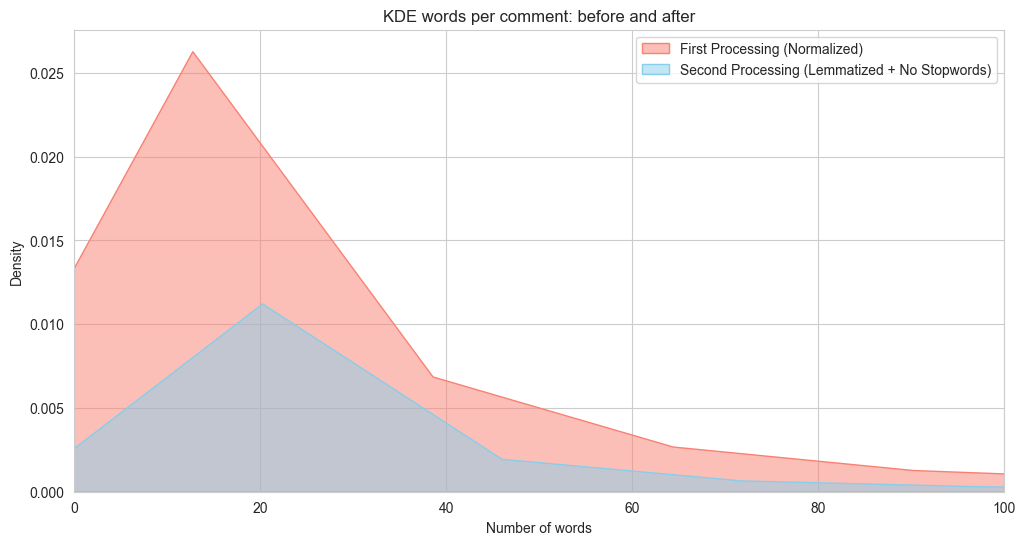

Mean Normalized Words: 32.67
Mean Clean Words: 14.05


In [7]:
plt.figure(figsize=(12, 6))

sns.kdeplot(df_supervised['n_words_normalized'], fill=True, label='First Processing (Normalized)', color='salmon', alpha=0.5)
sns.kdeplot(df_supervised['n_words_clean'], fill=True, label='Second Processing (Lemmatized + No Stopwords)', color='skyblue', alpha=0.5)

plt.title('KDE words per comment: before and after')
plt.xlabel('Number of words')
plt.ylabel('Density')
plt.xlim(0, 100)
plt.legend()
plt.show()

print(f"Mean Normalized Words: {df_supervised['n_words_original'].mean():.2f}")
print(f"Mean Clean Words: {df_supervised['n_words_clean'].mean():.2f}")

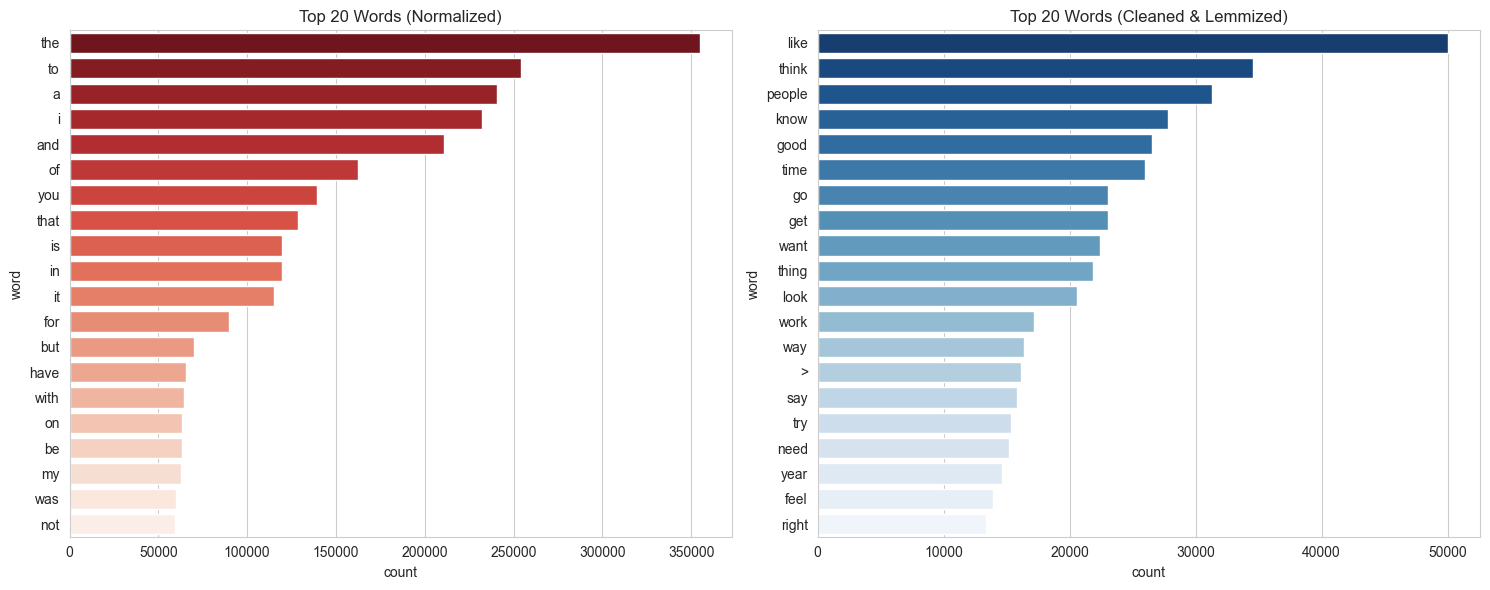

In [8]:
def get_top_words(body, n=20):
    all_body = ' '.join(body.fillna(''))
    words = all_body.split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['word', 'count'])

top_normalized = get_top_words(df_supervised['body_normalized'])
top_clean = get_top_words(df_supervised['body_clean'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(data=top_normalized, x='count', y='word', hue='word', ax=axes[0], palette='Reds_r', legend=False)
axes[0].set_title('Top 20 Words (Normalized)')

sns.barplot(data=top_clean, x='count', y='word', hue='word', ax=axes[1], palette='Blues_r', legend=False)
axes[1].set_title('Top 20 Words (Cleaned & Lemmized)')

plt.tight_layout()
plt.show()


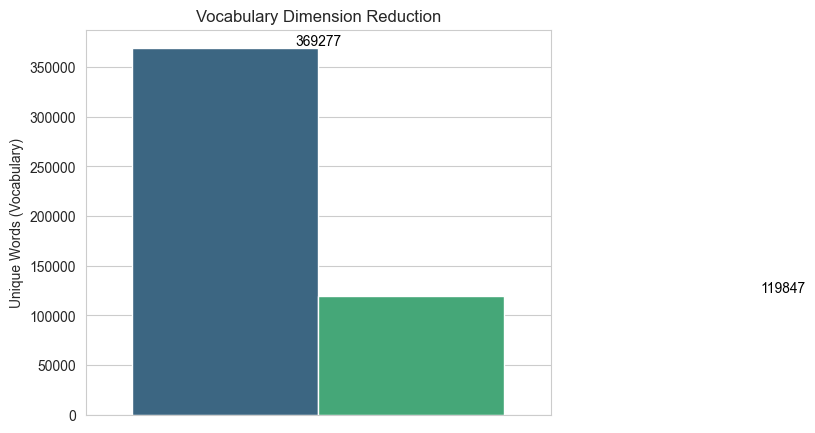

In [9]:
vocab_normalized = set(' '.join(df_supervised['body_normalized'].astype(str)).split())
vocab_clean = set(' '.join(df_supervised['body_clean'].astype(str)).split())

metrics = pd.DataFrame({
    'Stage': ['Normalized', 'Cleaned'],
    'Unique Words (Vocabulary)': [len(vocab_normalized), len(vocab_clean)]
})

plt.figure(figsize=(6, 5))
sns.barplot(
    data=metrics,
    y='Unique Words (Vocabulary)',
    hue='Stage',
    palette='viridis',
    legend=False
)
plt.title('Vocabulary Dimension Reduction')
for index, row in metrics.iterrows():
    plt.text(
        index,
        row['Unique Words (Vocabulary)'],
        f"{row['Unique Words (Vocabulary)']}",
        color='black',
        ha="center",
        va="bottom"
    )
plt.show()



In [10]:
from collections import Counter
from tqdm import tqdm

def check_non_alphanumeric(text_series):
    anomalies = Counter()
    text_list = text_series.fillna('').astype(str).tolist()
    for text in text_list:
        for char in text:
            if not char.isalpha() and not char.isspace():
                anomalies[char] += 1
    return anomalies

anomalie_trovate = check_non_alphanumeric(df_supervised['body_clean'])

print("\n--- CHECCKKK!!! ---")
print(f"Found {len(anomalie_trovate)} NON-alphabetic characters")
for char, count in anomalie_trovate.most_common():
    print(f"   Char: [{char}]  -  Compairs: {count}")



--- CHECCKKK!!! ---
Found 267 NON-alphabetic characters
   Char: [0]  -  Compairs: 48932
   Char: [1]  -  Compairs: 39077
   Char: [2]  -  Compairs: 30699
   Char: [3]  -  Compairs: 20485
   Char: [5]  -  Compairs: 19596
   Char: [>]  -  Compairs: 16323
   Char: [4]  -  Compairs: 15373
   Char: [.]  -  Compairs: 12249
   Char: [9]  -  Compairs: 10628
   Char: [6]  -  Compairs: 10237
   Char: [-]  -  Compairs: 9603
   Char: [8]  -  Compairs: 9400
   Char: [^]  -  Compairs: 9257
   Char: [7]  -  Compairs: 8573
   Char: [/]  -  Compairs: 7747
   Char: [$]  -  Compairs: 6094
   Char: [|]  -  Compairs: 4737
   Char: [']  -  Compairs: 3915
   Char: [~]  -  Compairs: 3799
   Char: [+]  -  Compairs: 3783
   Char: [(]  -  Compairs: 3259
   Char: [:]  -  Compairs: 3005
   Char: [=]  -  Compairs: 2794
   Char: [°]  -  Compairs: 2681
   Char: [_]  -  Compairs: 2626
   Char: [░]  -  Compairs: 2191
   Char: [,]  -  Compairs: 1562
   Char: [͜]  -  Compairs: 1421
   Char: [*]  -  Compairs: 1339
   Ch

## 3 Text Vectorization.

*a. Only for the supervised task (data_supervised.csv): Group and join all comments of the
same author, creating a “new” dataset to be used for the supervised task (Section 2).*

*b: As ML algorithms struggle to handle directly the raw textual data. You are required to
convert the text into numerical representations (vectors) through Bag of Words (BoW).*

*c: Another way to assign a vector representation to a word is to associate the TF-IDF
representation (Term Frequency-Inverse Document Frequency) to each user/comment.
Can you observe and explain the differences between the numerical representations
generated by BoW and TF-IDF?*


*A Wrap up section at the bottom describing which files are created and where by this notebook is at the very end of the notebook. To change the input file instead view the very first cell of the notebook. Originally meant for only the supervised dataset as described by the requirements.*

For problems contact Matteo Sottocornola on Telegram.

### Part 1 of 1.3

*Only for the supervised task (data_supervised.csv): Group and join all comments of the
same author, creating a “new” dataset to be used for the supervised task (Section 2).*

In [18]:
# TODO capire se aggiungere aggregated subreddit/created_utc

# import as panda dataframe.
import pandas as pd
import numpy as np

df = pd.read_csv("./clean_supervised.csv") #In principio da usare solo su clean_supervised.
print(df.shape)

(296042, 6)


In [19]:
#Drop the two unneeded columns inside clean_supervised
#Rename the cleaned body to just body cause I prefer that way.
df = df.drop(columns=['body','body_normalized'])
df = df.rename(columns={'body_clean':'body'})

In [20]:
print(df.shape)

(296042, 4)


In [21]:
#Non sicuro se anche questi andrano tenuti/concatenati come body quindi drop per ora.
df_text_only = df.drop(columns=['created_utc','subreddit'])
print(df_text_only)

#nella parte 2 di Rocco ci sono testi che diventano vuoti (e giusto cosi erano interamente composti da stop words).
#Qui li sto semplicemente togliendo. Da notare che alcuni utenti vanno scartati
#perche non hanno piu nessun commento.
print(df_text_only.shape)
df_text_only = df_text_only.dropna(subset=['body']) #perdiamo un 6000 su 296,000 posts.
print(df_text_only.shape)


                  author                                               body
0            Shamus_Aran  think nearly fanfiction picture ship ban ban l...
1               Riddance                             thanks get heart break
2          Secret_Wizard  sure confuse cyclop easy boss monster ogre tal...
3           Penultimatum                                            not bro
4              7-SE7EN-7                                          find mate
...                  ...                                                ...
296037            Tashre                             want play game anymore
296038  someguyfromtheuk  twist son stag discover reddit account ^^^i'm ...
296039       spurscanada  think lot people like end prefer short term po...
296040           SPAZZEH                        tea party have stroke right
296041      whslaxattack                       huge rof boost pretty e8 gun

[296042 rows x 2 columns]
(296042, 2)
(290725, 2)


In [22]:
#come richiesto per ogni autore dobbiamo avere una sola riga con tutti i body concatenati.
df_grouped = df_text_only.groupby('author')['body'].apply(" ".join).reset_index()
print(df_grouped)

              author                                               body
0             -Jared  neil diamond sweet caroline +1 chiropractor go...
1            -Peeter                                           read faq
2           -evasian  receive deathadder black edition yesterday try...
3            -rubiks  alunageorge good believe arctic monkey high an...
4     -true_neutral-  > urban ear metis ymmv different pair month di...
...              ...                                                ...
4989           zot13  hey think exactly happen 3rd party controller ...
4990           zottz  get stick traffic pre widen huey train go text...
4991         zukinzo  afraid good thing remake remaster release tire...
4992            zzrr  hear bakery go ah yeah wrong flower shop > cla...
4993         zzuil93  love like meteorite go quick come mean enjoy l...

[4994 rows x 2 columns]


In [23]:
#Quick sanity check.
i=4 #select an index, and as such a user.
user = df.iloc[i,0]
print("user: ", user," posted this: ", df.iloc[i, 3])

print(df.groupby("author").size().loc[user] )
#df.groupby("author").count()['author'=df.iloc[0, 0]]

row = df_grouped[df_grouped["author"] == user] #user
#print(row.iloc[0,1]) 
#You should see in the last print somewhere within the text a copy of the previously printed body.

user:  7-SE7EN-7  posted this:  find mate
635


In [24]:
#Convertiamo ad un numpy  per ragioni di efficenza/memoria.
numpy_grouped = df_grouped[["author","body"]].to_numpy()

### Part 2 of 1.3
*B: As ML algorithms struggle to handle directly the raw textual data. You are required to
convert the text into numerical representations (vectors) through Bag of Words (BoW).*

*Bag of Words (BoW) is a technique widely used to transform textual data into machine-readable format, specifically numerical values, without considering grammar and word order.*

*We will be counting the occurence of every word in the vocabulary we use. Where the word was and it's actual structure is lost. Basically you are adding a new column for each word that is in our dataset and adding the number of times it was used for each row.*

*Note that executing 1.2 to remove stop words first is heavily recomended to reduce the number of words and hence attributes we get with BoW.*

In [25]:
#useful example of BoW
#https://www.datacamp.com/tutorial/python-bag-of-words-model?dc_referrer=https%3A%2F%2Fwww.google.com%2F

from collections import defaultdict
import string

#df_grouped = df_grouped[:400] #remove after 1.2 available, done to reduce complexity for now.


#Dobbiamo creare un vocabolario di tutte le parole usate nei svariati body.
# Function to preprocess and tokenize
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenize: split the text into words
    tokens = text.split()
    return tokens


vocabulary = set()

for sentence in numpy_grouped[:, 1]:
    tokens = preprocess(sentence)
    vocabulary.update(tokens)

vocabulary = sorted(vocabulary)

print(len(vocabulary))


110157


In [26]:
#Create a dictionary so future lookups are O(1)
word2idx = {w:i for i,w in enumerate(vocabulary)}

def create_bow_vector(sentence):
    vector = [0] * len(word2idx)  # Initialize a vector of zeros
    for word in sentence:
        idx = word2idx.get(word)  # Find the index of the word in the vocabulary using dictionary.
        if idx is not None:
            vector[idx] += 1  # Increment the count at that index
    return vector

#initialize numpy_bow
numpy_bow = np.zeros((numpy_grouped.shape[0], len(vocabulary)), dtype=np.int32)

# Create BoW vector for each author, i.e. for each body in our numpy_grouped.
for i ,raw_text in enumerate(numpy_grouped[:,1]):
    tokens = preprocess(raw_text) #tokenize.
    temp = create_bow_vector(tokens)
    numpy_bow[i, :] = temp

#Lento perche troppe parole nel vocabulary.

In [27]:
np.set_printoptions(threshold=np.inf)
# most but not all will be zeroes, that's normal.

In [28]:
#Ci servira scrivere da qualche parte anche autori per ricordarci a chi corrisponde.
authors = numpy_grouped[:, 0]   # shape (n_auth,)

print(authors.shape)
print(numpy_bow.shape)

(4994,)
(4994, 110157)


In [29]:
#np.savetxt("1.3-bow-authors2.csv", authors, fmt="%s", delimiter=",")
#np.savetxt("1.3-bow_matrix.csv", numpy_bow, fmt="%d", delimiter=",")

np.save("1.3-bow_matrix.npy", numpy_bow)
np.save("1.3-bow-authors.npy", authors)
#poi si legge cosi.
#numpy_bow = np.load("bow_matrix.npy")
#authors = np.load("authors.npy")

### Part 3 of 1.3 - TF-IDF

*Another way to assign a vector representation to a word is to associate the TF-IDF
representation (Term Frequency-Inverse Document Frequency) to each user/comment.
Can you observe and explain the differences between the numerical representations
generated by BoW and TF-IDF?*

*For TF-IDF it is necessary to create the vocabulary of all the distinct words and then for each word performing the following calculation which requires computing these two first...*

![Fig1.png](Fig1.png)


*In practice for every word A and each user we calculate two metrics, one is what percentage of overall users used word A (log of this number). And the other is what percentage of the words used by that specific user correspond to A. The index is then the multiple of these two.*

*It's meant to provide a measure of how important each word is to that text, but corrected to cancel out words that are just common in general and not common to this specific text.*

In [30]:
#We reuse the vocabulary computed for the previous section so execute that first.
print(len(vocabulary))

110157


In [31]:
from collections import Counter
import math

# Count in how many documents each word appears
df_counter = Counter()

# Create BoW vector for each author, i.e. for each body in our numpy_grouped.
for raw_text in numpy_grouped[:,1]:
    tokens = preprocess(raw_text) #tokenize.
    unique_words = set(tokens)
    df_counter.update(unique_words)

N = authors.shape[0]            # number of documents

idf = [math.log(N / df_counter.get(word, 1)) for word in vocabulary]

In [32]:
print(type(idf))
print(len(idf))
print(len(vocabulary))

<class 'list'>
110157
110157


In [33]:
#now to compute the second metric TF and directly the TF-IDF
#word2idx from earlier is re used.

def create_TF_IDF_vector(sentence, idf):
    vector = [0] * len(idf)  # If not present in user's comment then TF-IDF is 0.
    
    for word in sentence:
        idx = word2idx.get(word)  # Find the index of the word in the vocabulary
        if idx is not None:
            vector[idx] += 1  # Increment the count at that index
    
    
    for i in range(len(idf)):
        vector[i] = vector[i] / len(sentence)
        vector[i] = vector[i] * idf[i]
    
    return vector

In [34]:
# Preallocate the full TF-IDF matrix
TFIDF_vectors = np.zeros((numpy_grouped.shape[0], len(idf)), dtype=float)


#TFIDF_vectors = []

# Create TF-IDF vector for each sentence in the processed corpus
for i, raw_text in enumerate(numpy_grouped[:,1]):
    tokens = preprocess(raw_text) #tokenize.
    #TFIDF_vectors.append(create_TF_IDF_vector(tokens,idf))
    temp = create_TF_IDF_vector(tokens, idf)
    TFIDF_vectors[i, :] = temp


In [35]:
print("Single DF-IDF row")
np.set_printoptions(threshold=np.inf)
#print(TFIDF_vectors[17])

Single DF-IDF row


In [36]:
#Debug - checks
ind = 0
for el in TFIDF_vectors[1]:
    if el != 0.0:
        print(el, ind)
    ind = ind + 1

2.0860935244930174 36451
0.5038768480805278 79596


In [37]:
#Debug - checks
print(idf[36451]*0.5, idf[79596]*0.5)

2.0860935244930174 0.5038768480805278


In [38]:
ind = 0
for el in TFIDF_vectors[18]:
    if el != 0.0:
        print(el, ind)
        print("index: ", ind, " TF-IDF: ", el, " for word: ", vocabulary[ind])
    ind = ind + 1

0.08754774235056602 23248
index:  23248  TF-IDF:  0.08754774235056602  for word:  come
0.3852838084106849 23757
index:  23757  TF-IDF:  0.3852838084106849  for word:  conclusion
1.0644990588549648 38974
index:  38974  TF-IDF:  1.0644990588549648  for word:  fortake
0.22357009324860788 86539
index:  86539  TF-IDF:  0.22357009324860788  for word:  share
0.10534616871475125 96080
index:  96080  TF-IDF:  0.10534616871475125  for word:  thank
0.060819953782309456 97111
index:  97111  TF-IDF:  0.060819953782309456  for word:  time
0.45041719813795833 102917
index:  102917  TF-IDF:  0.45041719813795833  for word:  ve
0.1842132873624969 107319
index:  107319  TF-IDF:  0.1842132873624969  for word:  write


In [39]:
#np.savetxt("1.3-tf_idf-authors.csv", authors, fmt="%s", delimiter=",")
#np.savetxt("1.3-tf_idf_matrix.csv", TFIDF_vectors, fmt="%d", delimiter=",")

np.save("1.3-tf-idf-matrix.npy", TFIDF_vectors)
np.save("1.3-tf-idf-authors.npy", authors)
#poi si legge cosi.
#numpy_bow = np.load("bow_matrix.npy")
#authors = np.load("authors.npy")

In [ ]:
import csv

with open("1.3-bow-vocabulary.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(vocabulary)
#check saved correctly
#with open("1.3-bow-vocabulary.csv", "r", encoding="utf-8") as f:
#    reader = csv.reader(f)
#    vocabulary2 = next(reader)

In [ ]:
#check saved correctly
#print(vocabulary)
#print(vocabulary2)

['\x04', '\x04dome', '\x04keyless', '\x04thing', '\x10”more', '0', '00', '000', '0000', '000000', '00000000', '00000000000011885195904108', '00000000001', '0000000001', '0000000010001001100000010000001100000100100010000', '000000001c', '000000002', '00000001', '000000044', '000000066', '0000001', '00000011875', '00000014', '00000018', '000000252', '000000385', '000000400', '00000043', '000001', '0000010', '000002', '000007', '000008699196', '00001', '00001778', '00002', '00009', '0001', '00014', '000147767', '000162', '0002', '00029', '00033x4', '00034x2', '0004', '0005', '0007', '0008', '00090529', '000gp', '001', '00100000', '00100111', '00101110', '0011', '0012', '0014', '0015', '0016', '0019', '001bc', '001–038', '002', '0020200', '00228', '0023', '00254', '0027', '00285x2', '003', '0030', '00303010', '0034', '004', '004012', '004019', '0042', '0045', '004607', '0048', '004–30', '005', '0050', '0051', '0052419', '0059', '005day', '005s', '005–030', '006', '00614', '0069', '007', '0

## 4 Reduce the complexity of your dataset.
*Threshold-based: BoW and TF-IDF representations use the same large vocabulary, which
can result in a very high-dimensional feature space. This may lead to issues like the curse of
dimensionality or even out-of-memory errors when processing the data. Use the BoW
representation to identify thresholds to reduce the dimensionality of the feature space of
either the BoW itself or the TF-IDF representation.*

*Hint: Consider removing words that are either too common or too rare, as they often carry
less useful information. One approach is to filter out words whose frequencies fall below a
lower quantile (Ql) or above an upper quantile (Qu).*

*Dimensionality Reduction: Try applying PCA to reduce the dimensionality of your features.
Does it work? How many components would you keep and why? Do the components you
obtain with PCA have a physical interpretation?*
*Note: The number of features is very large and both TF-IDF and BoW matrix are sparse.
Suggestion: Do not scale your dataset with StandardScaler. Indeed, subtracting the mean
from each feature will render the sparse matrix a dense one, drastically increasing memory
usage. Try working with the sparse format using scipy.sparse and apply Truncated SVD,
which is designed for sparse data.*


### Threshold-based

In [99]:
from scipy import sparse

In [100]:
bow_matr = np.load('1.3-bow_matrix.npy') 
authors = np.load('1.3-bow-authors.npy', allow_pickle=True) 

# print utilities
print(f"Original dimension: {bow_matr.shape}")
print(f"Type matrix: {type(bow_matr)}")

# converting in sparse matrix
bow_sparse = sparse.csr_matrix(bow_matr)
print(f"Dimensione sparsa: {bow_sparse.shape}")


# compute frequency of words (sum per column)
word_freq = np.array(bow_sparse.sum(axis=0)).flatten()

# some stats
print(f"Min freq: {word_freq.min()}")
print(f"Max freq: {word_freq.max()}")
print(f"Mean freq: {word_freq.mean():.2f}")
print(f"Median freq: {np.median(word_freq):.2f}")

# percentiles
percentiles = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
print("\nPercentiles distribution:")
for p in percentiles:
    print(f"  {p*100:2.0f}%: {np.quantile(word_freq, p):.2f}")




Original dimension: (4994, 110157)
Type matrix: <class 'numpy.ndarray'>
Dimensione sparsa: (4994, 110157)
Min freq: 1
Max freq: 50091
Mean freq: 37.42
Median freq: 1.00

Percentiles distribution:
   0%: 1.00
   1%: 1.00
   5%: 1.00
  10%: 1.00
  25%: 1.00
  50%: 1.00
  75%: 5.00
  90%: 26.00
  95%: 78.00
  99%: 652.44
  100%: 50091.00


### Visualization

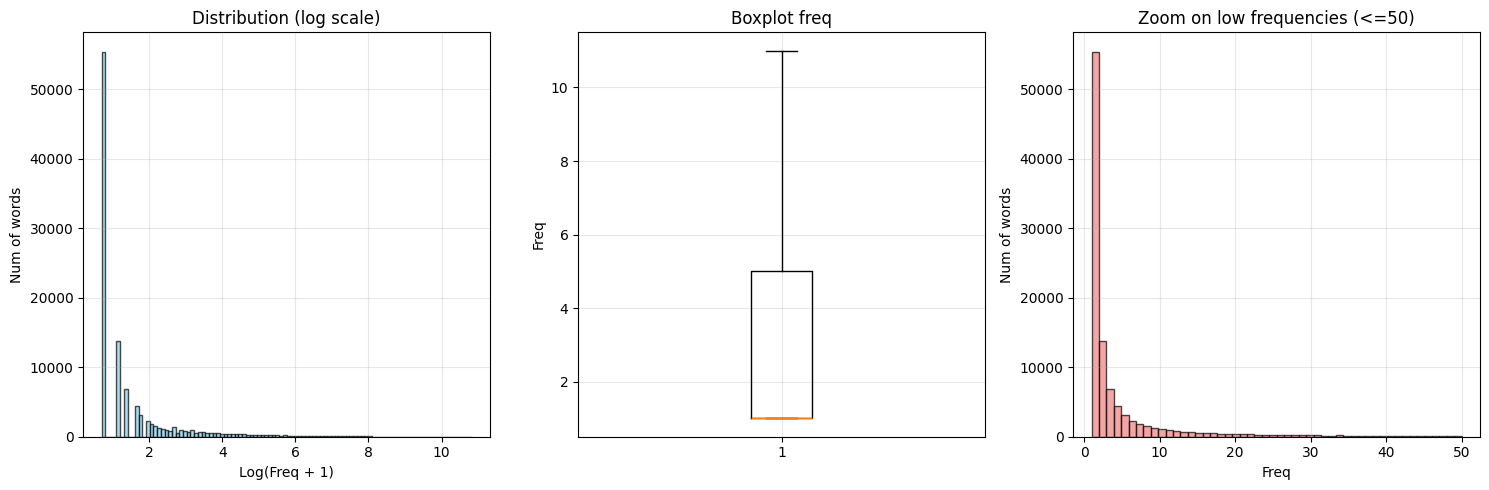

In [101]:
# visualization
plt.figure(figsize=(15, 5))

# Log distr
plt.subplot(1, 3, 1)
plt.hist(np.log1p(word_freq), bins=100, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Log(Freq + 1)')
plt.ylabel('Num of words')
plt.title('Distribution (log scale)')
plt.grid(True, alpha=0.3)

# Boxplot
plt.subplot(1, 3, 2)
plt.boxplot(word_freq, showfliers=False)
plt.ylabel('Freq')
plt.title('Boxplot freq')
plt.grid(True, alpha=0.3)

# Zoom on low freq
plt.subplot(1, 3, 3)
low_freq = word_freq[word_freq <= 50]  # Solo frequenze <= 50 per vedere meglio
plt.hist(low_freq, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Freq')
plt.ylabel('Num of words')
plt.title('Zoom on low frequencies (<=50)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### FIltering based on quantiles

In [102]:
#TODO togliere il Q_lower?

Q_lower = 0.01
Q_upper = 0.99

lower_threshold = np.quantile(word_freq, Q_lower)
upper_threshold = np.quantile(word_freq, Q_upper)

print(f"Quantilies choosen: {Q_lower} - {Q_upper}")
#print(f"Lower threshold (deleting words with freq <= {lower_threshold:.2f})")
print(f"Upper threshold (deleting words with freq >= {upper_threshold:.2f})")

# Apply the filtering
words_to_keep = (word_freq > lower_threshold) & (word_freq < upper_threshold)
#words_to_keep = (word_freq < upper_threshold)
bow_filtered = bow_sparse[:, words_to_keep]

# Stats of filtering
#words_removed_lower = (word_freq <= lower_threshold).sum()
words_removed_upper = (word_freq >= upper_threshold).sum()
words_kept = words_to_keep.sum()

print(f"\nResults:")
print(f"Words before: {len(word_freq)}")
#print(f"Removed rearest words: {words_removed_lower} ({words_removed_lower/len(word_freq)*100:.1f}%)")
print(f"Removed common words: {words_removed_upper} ({words_removed_upper/len(word_freq)*100:.1f}%)")
print(f"Words keeped: {words_kept} ({words_kept/len(word_freq)*100:.1f}%)")
print(f"Dim reducted: {(1 - words_kept/len(word_freq))*100:.1f}%")
print(f"Final BoW matrix: {bow_filtered.shape}")

Quantilies choosen: 0.01 - 0.99
Upper threshold (deleting words with freq >= 652.44)

Results:
Words before: 110157
Removed common words: 1102 (1.0%)
Words keeped: 53656 (48.7%)
Dim reducted: 51.3%
Final BoW matrix: (4994, 53656)


### Showing results

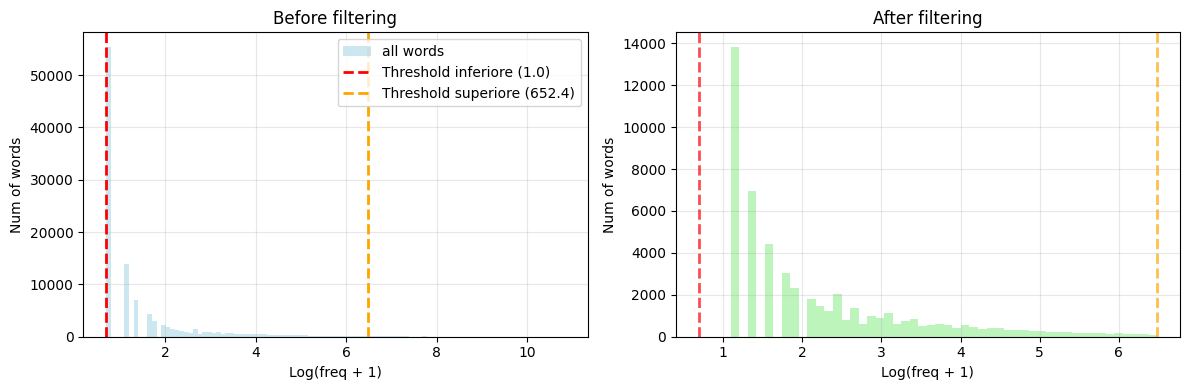

In [103]:
plt.figure(figsize=(12, 4))

# Before filtering
plt.subplot(1, 2, 1)
plt.hist(np.log1p(word_freq), bins=100, alpha=0.6, color='lightblue', label='all words')
plt.axvline(np.log1p(lower_threshold), color='red', linestyle='--', linewidth=2, 
            label=f'Threshold inferiore ({lower_threshold:.1f})')
plt.axvline(np.log1p(upper_threshold), color='orange', linestyle='--', linewidth=2, 
            label=f'Threshold superiore ({upper_threshold:.1f})')
plt.xlabel("Log(freq + 1)")
plt.ylabel("Num of words")
plt.title("Before filtering")
plt.legend()
plt.grid(True, alpha=0.3)

# After filtering
plt.subplot(1, 2, 2)
word_freq_filtered = word_freq[words_to_keep]
plt.hist(np.log1p(word_freq_filtered), bins=50, alpha=0.6, color='lightgreen')
plt.axvline(np.log1p(lower_threshold), color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.axvline(np.log1p(upper_threshold), color='orange', linestyle='--', linewidth=2, alpha=0.7)
plt.xlabel("Log(freq + 1)")
plt.ylabel("Num of words")
plt.title("After filtering")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

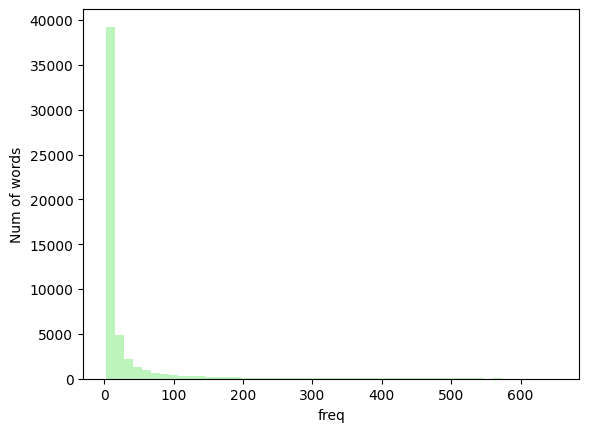

In [104]:
#TODO vogliamo aggiungere questo histograma senza log per il dopo?
#TODO da notare che e giusto lasciare quello in scala log per il confronto sopra.
plt.hist(word_freq_filtered, bins=50, alpha=0.6, color='lightgreen')
plt.xlabel("freq")
plt.ylabel("Num of words")
plt.show()

### Saving results

In [90]:
#TODO sicuro che dobbiamo salvare words_to_keep? Non credo ci servira.
# saving results
sparse.save_npz('1.4-bow_filtered_quantile.npz', bow_filtered)
np.save('1.4-words_kept_indices.npy', words_to_keep)

print(f"Files saved:")
print(f"1.4-bow_filtered_quantile.npz - Matrice BoW filtered")
print(f"1.4-words_kept_indices.npy - index words kept")

tfidf_matrix = np.load('1.3-tf-idf-matrix.npy')
tfidf_sparse = sparse.csr_matrix(tfidf_matrix)
tfidf_filtered = tfidf_sparse[:, words_to_keep]
sparse.save_npz('1.4-tfidf_filtered_quantile.npz', tfidf_filtered)
print(f"1.4-tfidf_filtered_quantile.npz - Matrix TF-IDF filtered")
print(f"Dimension filtered TF-IDF: {tfidf_filtered.shape}")

print(f"Dataset: {bow_sparse.shape[1]} features")
print(f"Dataset filtered: {bow_filtered.shape[1]} features") 
print(f"Final reduction: {(1 - bow_filtered.shape[1]/bow_sparse.shape[1])*100:.1f}%")

Files saved:
1.4-bow_filtered_quantile.npz - Matrice BoW filtered
1.4-words_kept_indices.npy - index words kept
1.4-tfidf_filtered_quantile.npz - Matrix TF-IDF filtered
Dimension filtered TF-IDF: (4994, 53656)
Dataset: 110157 features
Dataset filtered: 53656 features
Final reduction: 51.3%


## Appling the Truncated Singular Value Decomposition

In [59]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

In [60]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [61]:
#TODO lo so che dopo finiamo con proprio pochi attributi ma sicuro che
#non va applicato al dataset gia filtrato per quantili?
# load data
bow_matrix = np.load('1.3-bow_matrix.npy') 
bow_sparse = sparse.csr_matrix(bow_matrix)
print(f"BoW dimension: {bow_sparse.shape}")

tfidf_matrix = np.load('1.3-tf-idf-matrix.npy')
tfidf_sparse = sparse.csr_matrix(tfidf_matrix)
print(f"TF-IDF dimension: {tfidf_sparse.shape}")
has_tfidf = True

BoW dimension: (4994, 110157)
TF-IDF dimension: (4994, 110157)


In [ ]:
#TODO sicuro che serve salvarli?
# using sparse matrix
sparse.save_npz("bow_sparse.npz", bow_sparse)
sparse.save_npz("tfidf_sparse.npz", tfidf_sparse)

In [62]:
bow_sparse1 = sparse.load_npz("bow_sparse.npz")
print("BoW dimensions:", bow_sparse.shape)

tfidf_sparse1 = sparse.load_npz("tfidf_sparse.npz")
print("TF-IDF dimensions:", tfidf_sparse.shape)

BoW dimensions: (4994, 110157)
TF-IDF dimensions: (4994, 110157)


In [63]:
# k components keeped 
k = 100

# truncated svd on matrix to reducing the complexity
svd= TruncatedSVD(n_components=k, random_state=43)

# normalization of vectors
normalizer = Normalizer(copy =False)

# pipeline: svd and then normalization
lsa = make_pipeline(svd, normalizer)

# fit transform on BoW sparse matrix 
X_svd = lsa.fit_transform(bow_sparse1)

print(f"New shape after Truncated SVD: {X_svd.shape}")




New shape after Truncated SVD: (4994, 100)


In [ ]:
print("Explained variance ratio:", svd.explained_variance_ratio_.sum())

Explained variance ratio: 0.9144030957697673


In [ ]:
#TODO credo che manca qualcosa, volevi provare con diversi k e fare il plot?

# visualization of variance curve
plt.figure(figsize=(10, 6))
plt.plot(n_components_options, explained_variances, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance curve - Truncated SVD')
plt.grid(True, alpha=0.3)

NameError: name 'n_components_options' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Guide lines per 8'% - 90% of explained variance
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% of variance')
plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% of variance')
plt.legend()
plt.show()

In [66]:
# appling the truncated SVD

# choosing the number of components based of variance analysis
n_components_final = 1000  

print(f"Truncated SVD with {n_components_final} components...")

# For BoW
svd_bow = TruncatedSVD(n_components=n_components_final, random_state=42)
bow_svd = svd_bow.fit_transform(bow_sparse)
print(f"BoW after SVD: {bow_svd.shape}")

# For TF-IDF
svd_tfidf = TruncatedSVD(n_components=n_components_final, random_state=42)
tfidf_svd = svd_tfidf.fit_transform(tfidf_sparse)
print(f"TF-IDF after SVD: {tfidf_svd.shape}")

Truncated SVD with 1000 components...
BoW after SVD: (4994, 1000)
TF-IDF after SVD: (4994, 1000)


In [ ]:
# svd analysisi
print("First 10 components BoW - explained variance:")
for i, var in enumerate(svd_bow.explained_variance_ratio_[:10]):
    print(f"  Componente {i+1}: {var:.4f}")

# Total explained variance
total_variance_bow = svd_bow.explained_variance_ratio_.sum()
print(f"\ntotal explained variance BoW: {total_variance_bow:.3f}")

# Most important features
def print_top_features(svd_model, feature_names, n_features=10, n_components=3):
    """Stampa le feature più importanti per le prime componenti"""
    components = svd_model.components_
    for i in range(n_components):
        print(f"\nComponente {i+1} - Top features:")
        # Ottieni gli indici delle feature con peso assoluto più alto
        top_indices = np.argsort(np.abs(components[i]))[-n_features:][::-1]
        for idx in top_indices:
            # Nota: qui non abbiamo i nomi delle feature reali
            print(f"  Feature {idx}: peso {components[i][idx]:.4f}")

# Nota: Non abbiamo i nomi delle feature, quindi mostriamo solo gli indici
print("\nTop features per prime 3 componenti BoW:")
print("(Nota: senza nomi feature reali, mostro solo indici)")
for i in range(3):
    top_indices = np.argsort(np.abs(svd_bow.components_[i]))[-10:][::-1]
    print(f"Componente {i+1}: features {top_indices}")

#TODO la list vocabulary ce l'hai ancora ed e nello stesso ordine.
for i in range(3):
    top_indices = np.argsort(np.abs(svd_bow.components_[i]))[-10:][::-1]
    print(f"Componente {i+1}: features", end=" ")
    for idx in top_indices:
        print(vocabulary[idx], end=" ")
    print("")

First 10 components BoW - explained variance:
  Componente 1: 0.3945
  Componente 2: 0.1761
  Componente 3: 0.0866
  Componente 4: 0.0396
  Componente 5: 0.0207
  Componente 6: 0.0181
  Componente 7: 0.0157
  Componente 8: 0.0127
  Componente 9: 0.0115
  Componente 10: 0.0080

total explained variance BoW: 0.991

Top features per prime 3 componenti BoW:
(Nota: senza nomi feature reali, mostro solo indici)
Componente 1: features [ 57723  96503  73205  55016  42686 104701  97111  42413  58638  96479]
Componente 2: features [109377 109770 109625 109623  95562  60099  41449  76592  15629  55016]
Componente 3: features [ 52920  73205  69673  54724  57229  89011 108296  96503  58877  23248]
Componente 1: features like think people know good want time go look thing 
Componente 2: features ° ಠಠ ͡ ͜ʖ tell make gentoo pretty blade know 
Componente 3: features jon people oh kiss let smile yes think love come 


In [ ]:
# Saving matrix
np.save('1.4-bow_svd_reduced.npy', bow_svd)
np.save('1.4-tfidf_svd_reduced.npy', tfidf_svd)

# Salva i modelli SVD #TODO sicuro che vogliamo salvare i modelli abbiamo di piu in piu file in sta cartella.
import joblib
joblib.dump(svd_bow, '1.4-svd_bow_model.pkl')
joblib.dump(svd_tfidf, '1.4-svd_tfidf_model.pkl')

print(f"Original: {bow_sparse.shape} -> reducted: {bow_svd.shape}")
print(f"Reduction: {(1 - bow_svd.shape[1]/bow_sparse.shape[1])*100:.1f}%")
print(f"Preserved variance: {total_variance_bow*100:.1f}%")

Original: (4994, 110157) -> reducted: (4994, 1000)
Reduction: 99.1%
Preserved variance: 99.1%


In [79]:
# differences between truncated svd and threshold
try:
    bow_filtered = sparse.load_npz('1.4-bow_filtered_quantile.npz')
    print("CONFRONTO FINALE:")
    print(f"Threshold-based: {bow_filtered.shape} (mantiene parole reali)")
    print(f"Truncated SVD:    {bow_svd.shape} (componenti latenti)")
    print("\nVantaggi Threshold-based:")
    print("  • Features interpretabili (parole reali)")
    print("  • Mantiene semantica originale")
    print("\nVantaggi Truncated SVD:")
    print("  • Riduzione più aggressiva")
    print("  • Cattura correlazioni tra features")
    print("  • Meno sensibile al rumore")
    
except:
    print("Dati threshold-based non trovati per confronto")

CONFRONTO FINALE:
Threshold-based: (4994, 87743) (mantiene parole reali)
Truncated SVD:    (4994, 1000) (componenti latenti)

Vantaggi Threshold-based:
  • Features interpretabili (parole reali)
  • Mantiene semantica originale

Vantaggi Truncated SVD:
  • Riduzione più aggressiva
  • Cattura correlazioni tra features
  • Meno sensibile al rumore
